In [1]:
import numpy as np
from data_generator import BaseDataset
from dataset import DatasetGenerator
import matplotlib.pyplot as plt
import os
from eval_model import eval_pearsonsr, scale_preds
from keras.src.optimizers import Adam
from model import ModelTrainer
from sklearn.model_selection import KFold
from models_repo.LinearRegressor import LinearRegressor
from models_repo.LSTMRegressor import LSTMRegressor2L, LSTMRegressor

os.environ["CUDA_VISIBLE_DEVICES"] = "1"


2024-05-21 22:27:03.895354: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-21 22:27:03.895430: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-21 22:27:03.895466: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-21 22:27:03.908237: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_path = 'data'
dataset_path = 'dataset'
train_scalers_path = 'train-scalers'
columns = ['date', 'RSAM', 'T_olb', 'Ru_olb', 'P_olb', 'Rn_olb', 'T_msa',
           'Ru_msa', 'P_msa', 'Rn_msa', 'displacement (cm)',
           'background seismicity']
"""
    In questo punto carico i dati con i generator e li trasformo in X,y
"""
# dataset
dataset = BaseDataset(data_path=dataset_path)

In [4]:
# carico i dati, li divido e creo i generators
train_filenames, test_filenames = dataset.load_data(shuffle=False)
# li carico già divisi, non serve più splittarli
train_generator, test_generator, _, __ = dataset.generate_data(train_filenames, test_filenames)
# ottengo X_train,y_train ed X_test, y_test
X_train, y_train = dataset.generator_to_Xy(train_generator)
X_test, y_test = dataset.generator_to_Xy(test_generator)

In [7]:
rn = DatasetGenerator.get_ts_from_ds(X_train, -2)
rn_test = DatasetGenerator.get_ts_from_ds(X_test, -2)

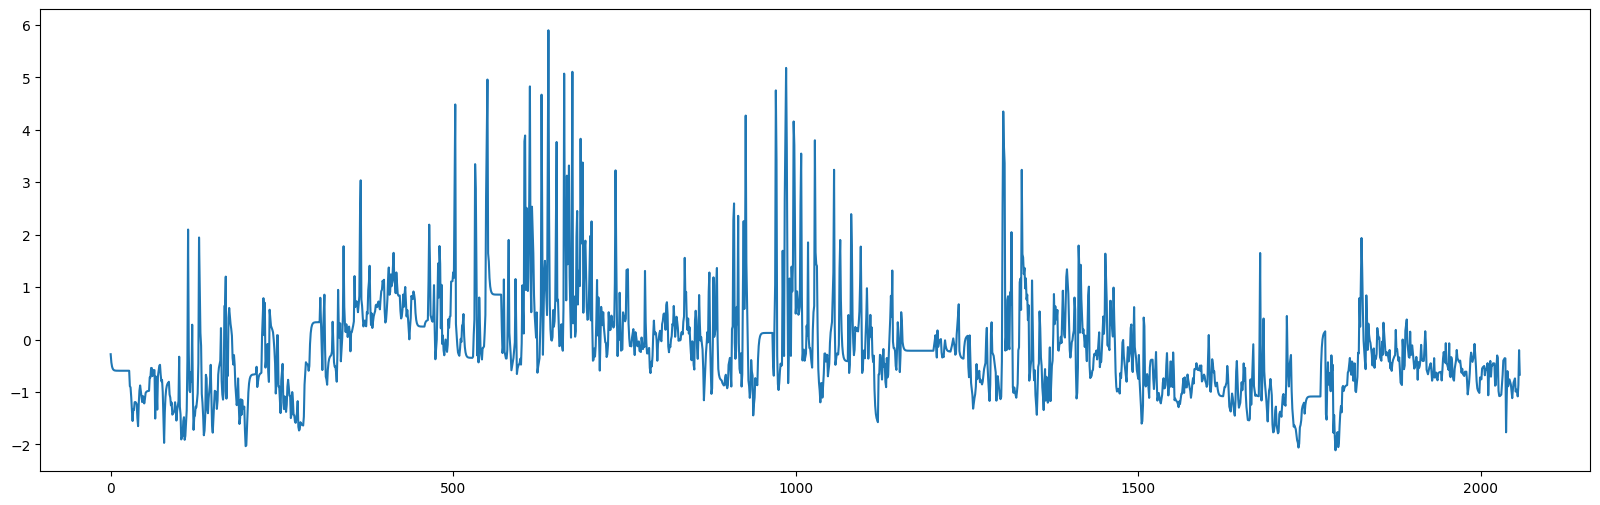

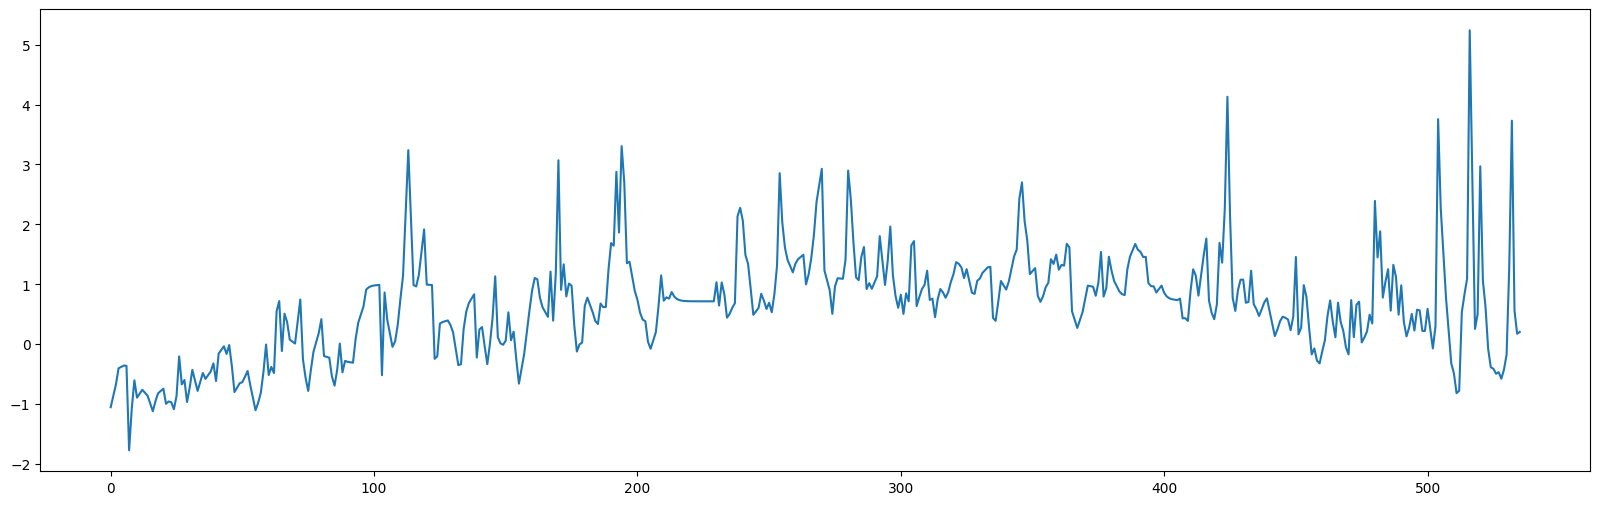

In [8]:
plt.figure(figsize=(20,6))
plt.plot(rn)
plt.figure(figsize=(20,6))
plt.plot(rn_test)

In [3]:
import string
import hashlib
import random
def generate_model_name():
    # Convert hyperparameters to a string
    letters = string.ascii_lowercase  # Use lowercase letters
    hyperparameters = ''.join(random.choice(letters) for i in range(20))

    hyperparameters_str = str(hyperparameters) + str(random.randint(1,1000))
    # Generate SHA-256 hash
    hash_object = hashlib.sha256(hyperparameters_str.encode())
    model_name = hash_object.hexdigest()[:8]  # Take first 8 characters for readability

    return model_name

In [ ]:
train_filenames, test_filenames = dataset.load_data(shuffle=False)
trainer = ModelTrainer(batch_size=64)
k = 5
kf = KFold(n_splits=k)
print(train_filenames.shape)
epochs = 512
loss = 'mae'

for train_index, val_index in kf.split(train_filenames):
    model_name =generate_model_name()
    train_fold_filenames, val_fold_filenames = train_filenames[train_index], train_filenames[val_index]
    # Split the training data into training and validation sets for this fold
    train_generator, valid_generator,input_shape, output_shape = dataset.generate_data(train_fold_filenames, val_fold_filenames)
    # genero il modello a che prende in considerazione input ed output shape
    regressor = LSTMRegressor(model_name=model_name)
    regressor.generate_model(input_shape, output_shape)

    # alleno il modello
    trainer.run(
        model=regressor.model,
        model_name=regressor.model_name,
        train={"filenames": train_fold_filenames, "generator": train_generator},
        test={'filenames': val_fold_filenames, 'generator': valid_generator},
        optimizer=Adam(learning_rate=0.001),
        epochs=epochs,
        loss=loss
    )

    print("accuracy test: ")
    _, test_generator, __, ___ = dataset.generate_data(train_filenames, test_filenames)
    lstm_y_preds = regressor.model.predict(test_generator)
    accuracy = regressor.model.evaluate(test_generator)

    scaler_path = 'scalers/'
    X_test, y_test = dataset.generator_to_Xy(test_generator)

    # eval_model.eval(model_name)
    regressor.model.evaluate(test_generator)

    eval_pearsonsr(lstm_y_preds, y_test, remove_outliers=False)

    y_true = y_test.reshape(y_test.shape[0], )
    scaled_y_true = scale_preds(y_true, scaler_path=f'{scaler_path}/Rn_olb_scaler.save')
    scaled_y_preds = scale_preds(lstm_y_preds, scaler_path=f'{scaler_path}/Rn_olb_scaler.save')

    rn = DatasetGenerator.get_ts_from_ds(X_test, -2)
    plt.figure(figsize=(20, 6), dpi=80)
    plt.plot(rn)
    plt.show()

    plt.plot(scaled_y_true, label='true')
    plt.plot(scaled_y_preds, label='preds')
    plt.legend()
    plt.show()

    # ottengo X_train,y_train ed X_test, y_test
    #X_train_fold, y_train_fold = dataset.generator_to_Xy(train_generator)
    #X_val_fold, y_val_fold = dataset.generator_to_Xy(valid_generator)

    #rn = DatasetGenerator.get_ts_from_ds(X_train_fold, y_train_fold, -2)
    #rn_test = DatasetGenerator.get_ts_from_ds(X_val_fold, y_val_fold, -2)
    #plt.figure(figsize=(20,6))
    #plt.plot(rn)
    #plt.figure(figsize=(20,6))
    #plt.plot(rn_test)

(2029, 2)


2024-05-21 22:27:15.833644: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15000 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:6d:00.0, compute capability: 6.0


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 18241 (71.25 KB)
Trainable params: 18241 (71.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/512


2024-05-21 22:27:18.894665: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


21/25 [========================>.....] - ETA: 0s - loss: 0.1223 - mae: 0.1223
Epoch 1: val_loss improved from inf to 0.09401, saving model to saved_model/f5a30305.x
INFO:tensorflow:Assets written to: saved_model/f5a30305.x/assets


INFO:tensorflow:Assets written to: saved_model/f5a30305.x/assets


25/25 [==============================] - 6s 115ms/step - loss: 0.1186 - mae: 0.1186 - val_loss: 0.0940 - val_mae: 0.0940 - lr: 0.0010
Epoch 2/512
22/25 [=========================>....] - ETA: 0s - loss: 0.0780 - mae: 0.0780
Epoch 2: val_loss improved from 0.09401 to 0.08035, saving model to saved_model/f5a30305.x
INFO:tensorflow:Assets written to: saved_model/f5a30305.x/assets


INFO:tensorflow:Assets written to: saved_model/f5a30305.x/assets


25/25 [==============================] - 3s 117ms/step - loss: 0.0763 - mae: 0.0763 - val_loss: 0.0803 - val_mae: 0.0803 - lr: 0.0010
